# IMPORT

In [1]:
#general imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from inspect import isfunction
from functools import partial
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as data
from torch.utils.data import Dataset
from torch import einsum

#torchvision
import PIL
from PIL import Image
import torchvision
from torchvision import datasets, transforms, utils

#einops
import einops
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

#ignite
from ignite.metrics import FID, InceptionScore
from ignite.engine import Engine

/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


# Utility functions

In [2]:
def plot_images(images, nbCol, nbRow, name):
    plt.figure(figsize=(32, 32))
    images = images.reshape(nbRow,nbCol,3,64,64)
    matrix = None
    for i in range(nbRow):
        for j in range(nbCol):
            r = torch.cat([torch.cat([im for im in images[i, : ,:, :, :].cpu()], dim=-1),], dim=-2).permute(1, 2, 0).to('cpu')
        if matrix is None:
            matrix = r
        else:
            matrix = torch.vstack((matrix, r))
            
    plt.imshow(matrix)
    plt.savefig(f'{name}')
    plt.show()
    
def expansion_size(vect):
    return torch.tensor(vect).view(-1,1,1,1)

# PARAMETERS

In [3]:
TYPE_SCHEDULE = 'linear'
BETA_START = 0.0001
BETA_END = 0.02             #ref values ?


IMAGE_SIZE = 64             # only consider square
IM2D_SIZE = (64,64)

MAX_TIMESTEP = 1000
NB_STEPS = 1000

S_COSINE = 0.008
device = 'cuda'

PI = torch.pi

# DIFFUSION CLASS

In [4]:
class GaussianDiffusion:
    def __init__(self, scheduleType = 'linear', device="cuda"):
        """
        Class of the diffusion processes.
        
        Args:
        -----
        - `scheduleType`: type of schedule
        - `device`: name of device
        """
        
        self.img_size = IMAGE_SIZE
        self.nbSteps = NB_STEPS               # number of step in scheduling
        
        ## for linear scheduling
        self.betaStart = BETA_START           # first value of beta
        self.betaEnd = BETA_END               # last value of beta
        
        ## for cosine scheduling
        #self.alphaStart = ALPHA_START
        #self.alphaStop = ALPHA_STOP
        
        
        self.imageSize = IMAGE_SIZE         # size of image

        self.alpha, self.beta, self.alpha_cumprod = self.getSchedule(scheduleType, MAX_TIMESTEP, NB_STEPS)       #define the schedule
        
        ### a update
        with torch.no_grad():
            self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)                                             # sqrt(a_bar)
            self.one_minus_alpha_cumprod = 1. - self.alpha_cumprod                                               # 1- a_bar
            self.sqrt_one_minus_alpha_cumprod = torch.sqrt(self.one_minus_alpha_cumprod)                         # sqrt(1-a_bar)
            
            self.prev_alpha_cumprod = torch.cat((torch.tensor([1.0]).to('cuda'), self.alpha_cumprod[:-1]))       # [1, a_bar[:-1]]
            self.sqrt_prev_alpha_cumprod = torch.sqrt(self.prev_alpha_cumprod)                                   # sqrt([1, a_bar[:-1]])
            self.coef1 = torch.sqrt((1-self.alpha_cumprod)/(self.alpha_cumprod))                                 # sqrt((1-a_bar)/(a_bar))
            self.inv_sqrt_alpha_cumprod = 1/torch.sqrt(self.alpha_cumprod)                                       # 1/sqrt(a_bar)
            self.sqrt_beta = torch.sqrt(self.beta)                                                               # sqrt(beta)
                    
        
    def getRandomTimestep(self, nb):
        """
        Returns nb random timesteps
        """
        
        return torch.randint(low=1, high=self.nbSteps, size=(nb,))  # self.nbSteps+1
    
    def getSchedule(self, scheduleType, maxTimeStep, nbSteps):
        """
        Generates the schedule.
        
        This function will define alpha, beta and alpha_cumprod in the class
        
        Args:
        -----
        - `scheduleType`: type of schedule
                         - linear scheduling
                         - cosine scheduling
        - `nbSteps`: number of steps in the diffusion process
        - `device`: gpu device
        
        """
        
        if scheduleType =='linear':
            with torch.no_grad():
                beta = torch.linspace(self.betaStart, self.betaEnd, nbSteps)
                alpha = 1-beta
                alpha_cumprod = torch.cumprod(alpha, dim=0)
            
        elif scheduleType =='cosine':
            
            with torch.no_grad():
                timesteps = torch.linspace(0, maxTimeStep, nbSteps+1)
                s = S_COSINE

                alpha_cumprod = torch.square(torch.cos( ( ( (timesteps/maxTimeStep) + s) * torch.pi) / ((1+s) * 2) ) )
                alpha_cumprod = alpha_cumprod/alpha_cumprod[0]

                beta = torch.clip(1-(alpha_cumprod[1:] / alpha_cumprod[:-1]), 0.0001, 0.9999)
                #beta *= self.betaEnd

                alpha = 1-beta
                alpha_cumprod = torch.cumprod(alpha, dim=0)
                
            
        alpha = alpha.to(device)
        beta = beta.to(device)
        alpha_cumprod = alpha_cumprod.to(device)
        
        return alpha, beta, alpha_cumprod

        
    def noise_images(self, x, t):
        """
        Make images noisy (can either do it in multiple steps (to do for furhter improvements) or in a single one)
        
        Args:
        -----
        - `x`: normalized initial image
        - `t`: timestep of the sampled image
        
        Output:
        -------
        Noisy iamge
        """
        
        with torch.no_grad():
            a = self.sqrt_alpha_cumprod[t].view(-1,1,1,1)
            b = self.sqrt_one_minus_alpha_cumprod[t].view(-1,1,1,1)
            noise = torch.randn_like(x)
            return a * x + b * noise, noise
        
    
    def DDIM_sampling(self, model, n, selectedTimesteps, x=None):
        """
        Implementation of a DDIM sampler
        
        Args:
        -----
        - `model`: model of diffusion
        - `n`: number of noisy images to deal with
        - `selectedTimesteps`: selected timesteps for the DDIM sampler [0, delta, 2 delta, ..., T]
        
        Output:
        -------
        A denoised image
        """
        
        model.eval()
        
        with torch.no_grad():
            
            if x is None:
                x = torch.randn((n, 3, self.img_size, self.img_size)).to(device)    # sampling from normal distribution for x_T
                
            
            for i in reversed(range(len(selectedTimesteps))):                 # go through the timesteps
                                        
                if i < 1:
                    # hypothesis: start at 0
                    break
                
                val = selectedTimesteps[i]           # at t
                valNext = selectedTimesteps[i-1]     # at t - delta
                
                t = (torch.ones(n) * val).long().to(device)
                tNext = (torch.ones(n) * valNext).long().to(device)
                
                predicted_noise = model(x, t)
                
                # sqrt(a_bar)
                a = self.sqrt_alpha_cumprod[tNext].view(-1,1,1,1)  
                # 1/sqrt(a_bar)
                b = self.inv_sqrt_alpha_cumprod[t].view(-1,1,1,1)
                
                # sqrt(1-a_bar)
                c = self.sqrt_one_minus_alpha_cumprod[tNext].view(-1,1,1,1)
                d = self.sqrt_one_minus_alpha_cumprod[t].view(-1,1,1,1)
                
                coef1 = a*b
                coef2 = c - coef1 * d

                x = coef1 * x + coef2 * predicted_noise
                
                
            x = (x.clamp(-1, 1) + 1) / 2
        
        model.train()
        
        return x
    

    def sample(self, model, n, x=None):
        """
        Implementation of algo 2 from DDPM paper
                
        Args:
        -----
        - `model`: model of diffusion
        - `n`: number of noisy images to deal with
        
        Output:
        -------
        A denoised image
        """
        
        model.eval()
        
        with torch.no_grad():
            
            if x is None:
                x = torch.randn((n, 3, self.img_size, self.img_size)).to(device)    # sampling from normal distribution for x_T
            
            for i in tqdm(reversed(range(1, self.nbSteps)), position=0):         # go through the timesteps
                
                t = (torch.ones(n) * i).long().to(device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t].view(-1,1,1,1)
                alpha_cumprod = self.alpha_cumprod[t].view(-1,1,1,1)
                beta = self.beta[t].view(-1,1,1,1)
                
                if i > 1:
                    noise = torch.randn_like(x)                                      # don't need noise at the last step (i = 1 ? not 0 ?)
                else:
                    noise = torch.zeros_like(x)
                    
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_cumprod))) * predicted_noise) + torch.sqrt(beta) * noise
                
            x = (x.clamp(-1, 1) + 1) / 2
        
        model.train()
        
        return x
    
    def repaint(self,n, x_0,model,U,mask = None, inv_mask = None):
        """
        Implementation of the repaint algorithm
        
        Allows to complete a mask of the image
        
        Args:
        -----
        - `x_0`: initial image
        - `model`: diffusion model
        - `U`:
        - `mask`: mask to use
        
        Output:
        -------
        A denoised image
        """
        model.eval()
        
        with torch.no_grad():
            
            ## define a standard mask if none is inputed
            if mask is None:
                mask = torch.ones_like(x_0).to(device)
                inv_mask = torch.zeros_like(x_0).to(device)
                inv_mask[:, :,10:30,10:50] = 1
                mask[:, :,10:30,10:50] = 0
                
                plt.imshow((mask*x_0)[0].permute(1,2,0).to('cpu'))
                plt.show()
                
                
            x_t = torch.randn_like(x_0).to(device)             # defines a gaussian noise for x_T
            
            for t in tqdm(reversed(range(self.nbSteps))):
                
                t_b = (torch.ones(n) * t).long().to(device)
                
                for u in range(U):
                    if t > 0:
                        eps = torch.randn_like(x_t).to(device)
                        z = torch.randn_like(x_t).to(device)
                    else:
                        print(t)
                        eps = torch.zeros_like(x_t).to(device)
                        z = torch.zeros_like(x_t).to(device)

                    x_minus_known = self.sqrt_alpha_cumprod[t]*x_0 + self.one_minus_alpha_cumprod[t]*eps
                    x_minus_unknown = (1/torch.sqrt(self.alpha[t]))*(x_t - self.beta[t]/self.sqrt_one_minus_alpha_cumprod[t]*model(x_t,t_b)) + torch.sqrt(self.beta[t]) * z
                    x_minus = x_minus_known * mask + inv_mask * x_minus_unknown
                    
                        
                    if u < (U-1) and t > 0:
                        x_t = torch.randn_like(x_0).to(device) * self.beta[t-1]
                        x_t += torch.sqrt(1-self.beta[t-1])*x_minus
                        
                x_t = x_minus  
                
        model.train()
        return x_t
    
    
    
    def repaint_DDIM(self,x_0, n, selectedTimesteps, model, U=1, mask = None):
        """
        Implementation of the repaint algorithm
        
        Allows to complete a mask of the image
        
        Args:
        -----
        - `x_0`: initial image
        - `model`: diffusion model
        - `mask`: mask to use
        
        Output:
        -------
        A denoised image
        """
        model.eval()
        
        with torch.no_grad():
            
            ## define a standard mask if none is inputed
            if mask is None:
                mask = torch.ones_like(x_0).to(device)
                inv_mask = torch.zeros_like(x_0).to(device)
                inv_mask[:,:,:,32:] = 1
                mask[:,:,:,32:] = 0
                
                
            x_t = torch.randn_like(x_0).to(device)             # defines a gaussian noise for x_T
            
            for i in tqdm(reversed(range(len(selectedTimesteps)))):                 # go through the timesteps
                                        
                if i < 1:
                    #val = selectedTimesteps[i]           # at t
                    #valNext = selectedTimesteps[i]     # at t - delta
                    break
                else:    
                    val = selectedTimesteps[i]           # at t
                    valNext = selectedTimesteps[i-1]     # at t - delta
                
                t = (torch.ones(n) * val).long().to(device)
                tNext = (torch.ones(n) * valNext).long().to(device)
                
                a = self.sqrt_alpha_cumprod[tNext].view(-1,1,1,1)  
                # 1/sqrt(a_bar)
                b = self.inv_sqrt_alpha_cumprod[t].view(-1,1,1,1)
                
                # sqrt(1-a_bar)
                c = self.sqrt_one_minus_alpha_cumprod[tNext].view(-1,1,1,1)
                d = self.sqrt_one_minus_alpha_cumprod[t].view(-1,1,1,1)
                
                coef1 = a*b
                coef2 = c - coef1 * d
                
                for u in range(U):

                    predicted_noise = model(x_t, t)

                    #if i > 0:
                    #    eps = torch.randn_like(x_t).to(device)
                    #    z = torch.randn_like(x_t).to(device)
                    #else:
                    #    print(t)
                    #    eps = torch.zeros_like(x_t).to(device)
                    #    z = torch.zeros_like(x_t).to(device)

                    eps = torch.randn_like(x_t).to(device)
                    z = torch.randn_like(x_t).to(device)

                    x_minus_known = self.sqrt_alpha_cumprod[t]*x_0 + self.one_minus_alpha_cumprod[t]*eps
                    x_minus_unknown = coef1 * x_t + coef2 * predicted_noise
                    x_minus = x_minus_known * mask + inv_mask * x_minus_unknown
                    
                    if u > 0:
                        x_t = torch.sqrt(1-self.beta[tNext])*x_minus + torch.randn_like(x_minus).to(device) * self.beta[tNext]


                x_t = x_minus  
                
        model.train()
        return x_t
    


# MODELE ARCHITECTURE

In [5]:
class StandardizedConv(nn.Conv2d):
    """
    Based on: https: //arxiv.org/abs/1903.10520
    Code inspired from: https://github.com/joe-siyuan-qiao/WeightStandardization
    
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

class TimeMLP(nn.Sequential):
    def __init__(self,dim_in,dim_out):
        super(TimeMLP,self).__init__()
        self.silu = nn.SiLU()
        self.lin = nn.Linear(dim_in,dim_out)
    
class ResBlock(nn.Module):
    def __init__(self,dim_in,dim_out,dim_time,down = True,groups=4):
        super(ResBlock,self).__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dim_time = dim_time
        self.ngroups = groups
        self.time_mlp = TimeMLP(dim_time,dim_in)
        if down:
            self.conv1 = StandardizedConv(dim_in,dim_in,kernel_size=3,padding = 1)
            self.group_norm1 = nn.GroupNorm(groups,dim_in)
            self.silu1 = nn.SiLU()
            self.conv2 = StandardizedConv(dim_in,dim_out,kernel_size=3,padding = 1)
            self.group_norm2 = nn.GroupNorm(groups,dim_out)
            self.silu2 = nn.SiLU()
        else:
            self.conv1 = StandardizedConv(dim_in,dim_out,kernel_size=3,padding = 1)
            self.group_norm1 = nn.GroupNorm(groups,dim_out)
            self.silu1 = nn.SiLU()
            self.conv2 = StandardizedConv(dim_out,dim_out,kernel_size=3,padding = 1)
            self.group_norm2 = nn.GroupNorm(groups,dim_out)
            self.silu2 = nn.SiLU()
        
        if dim_in == dim_out:    
            self.residual_conn = nn.Identity()
        else:
            self.residual_conn = nn.Conv2d(dim_in,dim_out,1)
            
    def forward(self,x,t):
        t_embedding = self.time_mlp(t) #[NBATCH,DIMIN]
        t_embedding = rearrange(t_embedding, "batch dim -> batch dim 1 1") #4d to broadcast the embedding on the images
        h = t_embedding + x
        h = self.conv1(h)
        h = self.group_norm1(h)
        h = self.silu1(h)
        h = self.conv2(h)
        h = self.group_norm2(h)
        h = self.silu2(h)
        
        return h + self.residual_conn(x)
    
class Downsample(nn.Sequential):
    def __init__(self,factor):
        super(Downsample,self).__init__()
        self.pool = nn.MaxPool2d(factor)

class Upsample(nn.Sequential):
    def __init__(self,factor,chan_in):
        super(Upsample,self).__init__()
        self.up = nn.Upsample(scale_factor=factor, mode="nearest")
        self.conv = nn.Conv2d(chan_in, int(chan_in/2),kernel_size=1)

class SinusoidalPositionEmbeddings(nn.Module):
    """
    Code inspired from: https://github.com/wzlxjtu/PositionalEncoding2D
    """
    
    # Class for position embeddings
    def __init__(self, dim):
        super().__init__()
        #dim is the dimension of the time embeddings
        self.dim = dim

    def forward(self, time):
        # takes as input a vector of size Nbatch,1 containing the noise level of each image
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        #output a tensor of size (Nbatch,dim) containing the embeddings of the noise levels
        return embeddings
    
class SelfAttentionBlock(nn.Module):
    def __init__(self,n_channels,size_image,n_heads = 4):
        super(SelfAttentionBlock,self).__init__()
        self.n_chan = n_channels
        self.size_image = int(size_image)
        self.heads = n_heads
        self.mha = nn.MultiheadAttention(n_channels, n_heads, batch_first=True)
        self.normalize_layer = nn.LayerNorm([n_channels])
        self.mlp = nn.Sequential(
            nn.LayerNorm([n_channels]),
            nn.Linear(n_channels, n_channels),
            nn.GELU(),
            nn.Linear(n_channels, n_channels),
        )
    def forward(self,x):
        x_flat = x.view(-1,self.n_chan,int(self.size_image * self.size_image)).permute(0,2,1)
        x_flat_normalized = self.normalize_layer(x_flat)
        self_attention,_ = self.mha(x_flat_normalized,x_flat_normalized,x_flat_normalized)
        output = self.mlp(x_flat + self_attention)
        
        return output.permute(0,2, 1).view(-1, self.n_chan, self.size_image, self.size_image)
        
class CrossAttentionBlock(nn.Module):
    def __init__(self,n_channels,size_image,n_heads = 4):
        super(CrossAttentionBlock,self).__init__()
        self.n_chan = n_channels
        self.size_image = int(size_image)
        self.heads = n_heads
        self.mha = nn.MultiheadAttention(n_channels, n_heads, batch_first=True)
        self.normalize_layer = nn.LayerNorm([n_channels])
        self.mlp = nn.Sequential(
            nn.LayerNorm([n_channels]),
            nn.Linear(n_channels, n_channels),
            nn.GELU(),
            nn.Linear(n_channels, n_channels),
        )
        self.conv = nn.Conv2d(n_channels * 3, n_channels * 2, 1)
    
    def forward(self,x_down,x_up):
        x_down_flat = x_down.view(-1,self.n_chan,int(self.size_image * self.size_image)).permute(0,2,1)
        x_down_flat_normalized = self.normalize_layer(x_down_flat)
        x_up_flat = x_up.view(-1,self.n_chan,int(self.size_image * self.size_image)).permute(0,2,1)
        x_up_flat_normalized = self.normalize_layer(x_up_flat)
        self_attention,_ = self.mha(x_down_flat_normalized,x_up_flat_normalized,x_up_flat_normalized)
        self_attention = self_attention.permute(0,2,1).reshape(-1,self.n_chan,self.size_image,self.size_image)
        output = torch.cat((x_down,x_up,self_attention),1)
        
        return self.conv(output)
    
class Unetvf(nn.Module):
    def __init__(self,c_in,c_in_net,heads,img_size):
        super(Unetvf,self).__init__()
        #convert Nbatch x 3 x im_size x im_size into Nbatch x 64 x im_size x im_size
        self.init_conv = nn.Conv2d(c_in,c_in_net,1)
        #embedding of time
        self.time_embed = SinusoidalPositionEmbeddings(256)
        
        #Down part of the U
        #x0: Nbatch x 64 x img_size x img_size
        self.resD1 = ResBlock(c_in_net,c_in_net,256)
        #x1: Nbatch x 64 x 64 x 64
        self.down1 = Downsample(2)
        #x2: Nbatch x 64 x 32 x 32
        self.resD2 = ResBlock(c_in_net,c_in_net*2,256)
        #x3: Nbatch x 128 x 32 x 32
        self.down2 = Downsample(2)
        #x4: Nbatch x 128 x 16 x 16
        self.att1 = SelfAttentionBlock(c_in_net*2,img_size/4)
        #x5: Nbatch x 128 x 16 x 16
        self.resD3 = ResBlock(c_in_net*2,c_in_net*4,256)
        #x6: Nbatch x 256 x 16 x 16
        self.down3 = Downsample(2)
        #x7: Nbatch x 256 x 8 x 8
        self.att2 = SelfAttentionBlock(c_in_net*4,img_size/8)
        #x8: Nbatch x 256 x 8 x 8
        self.resD4 = ResBlock(c_in_net*4,c_in_net*8,256)
        #x9: 512 x 8 x 8
        self.att3 = SelfAttentionBlock(c_in_net*8,img_size/8)
        self.resD5 = ResBlock(c_in_net*8,c_in_net*8,256)
        #x10: 512 x 8 x 8
        self.up1 = Upsample(2,c_in_net*8)
        #x11: 256 x 16 x 16
        self.ca1 = CrossAttentionBlock(c_in_net*4,img_size/4)
        #x12: 512 x 16 x 16
        self.resU1 = ResBlock(c_in_net*8, c_in_net*4,256)
        #x13: 256 x 16 x 16
        self.up2 = Upsample(2,c_in_net*4)
        #x14: 128 x32 x32
        #concat
        #x15: 256 x 32 x 32
        self.resU2 = ResBlock(c_in_net*4, c_in_net*2,256)
        #x16: 128 x 32 x 32
        self.up3 = Upsample(2,c_in_net*2)
        #x17: 64 x 64 x 64
        #concat
        #x18: 128 x 64 x 64
        self.resU3 = ResBlock(c_in_net*2, c_in_net*1,256)
        #x19: 64 x 64 x 64
        self.end_conv = nn.Conv2d(c_in_net,c_in,1)
        #x20
    def forward(self,x,t):
        x0 = self.init_conv(x)
        t_emb = self.time_embed(t)
        x1 = self.resD1(x0,t_emb)
        x2 = self.down1(x1)
        x3 = self.resD2(x2,t_emb)
        x4 = self.down2(x3)
        x5 = self.att1(x4)
        x6 = self.resD3(x5,t_emb)
        x7 = self.down3(x6)
        x8 = self.att2(x7)
        x9 = self.resD4(x8,t_emb)
        x10 = self.att3(x9)
        x10 = self.resD5(x10,t_emb)
        x11 = self.up1(x10)
        x12 = self.ca1(x6,x11)
        x13 = self.resU1(x12,t_emb)
        x14 = self.up2(x13)
        x15 = torch.cat((x3,x14),1)
        x16 = self.resU2(x15,t_emb)
        x17 = self.up3(x16)
        x18 = torch.cat((x1,x17),1)
        x19 = self.resU3(x18,t_emb)
        x20 = self.end_conv(x19)
        return x20

# Dataset

In [6]:
import os 


list_images = {}
list_images['train'] = []
list_images['eval'] = []
list_images['test'] = []
list_images['metric'] = []

#path = os.path.join(os.getcwd(), 'data_celeba256/arch')
path = os.path.join(os.getcwd(), 'data_celeba64/arch')

for root, dirs, files in tqdm(os.walk(path)):
    #print(files)
    #print(len(files))
    for file in files:    
        if file.endswith(".jpg"):
            list_images['metric'].append(os.path.join(root, file))
            if len(list_images['train']) < 20000:
                list_images['train'].append(os.path.join(root, file))
            else:
                list_images['test'].append(os.path.join(root, file))
            
print(len(list_images['train']))
print(len(list_images['test']))

1it [00:00,  8.97it/s]

20000
10000


(64, 64)


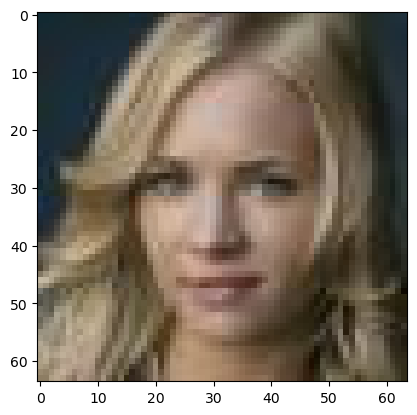

In [7]:
from PIL import Image

im = Image.open(list_images['train'][548]).convert('RGB') #313
print(im.size)
plt.imshow(im)

In [8]:
image_size = (64,64)

tr_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),           # modify those values ?
])


# modify this transform
transform_v0 = torchvision.transforms.Compose([
        torchvision.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
        torchvision.transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [9]:
from PIL import Image

class ImageDataset(Dataset):
    """
    Class to prepare the data for a neural network in pyTorch. The database is composed of 3 tables:
    - Video: to save the video information
    - Sequence: to save the sequence information labelled with the soccer actions and record the sound of the sequence
    - Image: to save the image information of the sequence
    """
    
    def __init__(self, data_list, features, transform=None):
        """
        - `data_list`: list of paths to data
        - `features`: tensor of features
        - `transform`: transformation in the dataloader 
        """
        
        self.data_list = data_list
        self.transform = transform
        self.feats = features
        self.len_list = len(data_list)
        
    def __len__(self):
        return self.len_list
    
    def __getitem__(self, idx):
        
        im = Image.open(self.data_list[idx]).convert('RGB')
                                        
        if self.transform:
            return self.transform(im),  self.feats[idx, :]

        return im, self.feats[idx, :]

In [10]:
features = torch.load("features_64_v2.pt").to("cuda")
featuresLearning = torch.load("features_64_v2.pt").to('cpu')
print(features.shape)

torch.Size([30000, 2048])


In [11]:
datasetLearning = ImageDataset(list_images['metric'], featuresLearning, transform = tr_base)
loaderLearning = data.DataLoader(datasetLearning, batch_size = 50, shuffle= True, num_workers = 2)

# SAMPLING

tensor([  0,  25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325,
        350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675,
        700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 999])
tensor([[[0.3503, 0.2559, 0.2080,  ..., 0.8824, 0.8940, 0.9249],
         [0.3311, 0.2565, 0.2115,  ..., 0.8938, 0.9010, 0.9168],
         [0.3226, 0.2455, 0.2108,  ..., 0.9150, 0.9092, 0.9200],
         ...,
         [0.9964, 0.9731, 0.9568,  ..., 0.7046, 0.7334, 0.6216],
         [0.9698, 0.9576, 0.9378,  ..., 0.7252, 0.6987, 0.6032],
         [0.9348, 0.9070, 0.8743,  ..., 0.7184, 0.6448, 0.5614]],

        [[0.3070, 0.2341, 0.1989,  ..., 0.8766, 0.8980, 0.9455],
         [0.2974, 0.2340, 0.2066,  ..., 0.8818, 0.8932, 0.9114],
         [0.2914, 0.2228, 0.1792,  ..., 0.8948, 0.8872, 0.9159],
         ...,
         [0.9515, 0.9345, 0.9180,  ..., 0.5817, 0.6154, 0.5027],
         [0.9210, 0.9044, 0.8904,  ..., 0.6013, 0.5731, 0.4704],
         [0.8851, 0.8567,

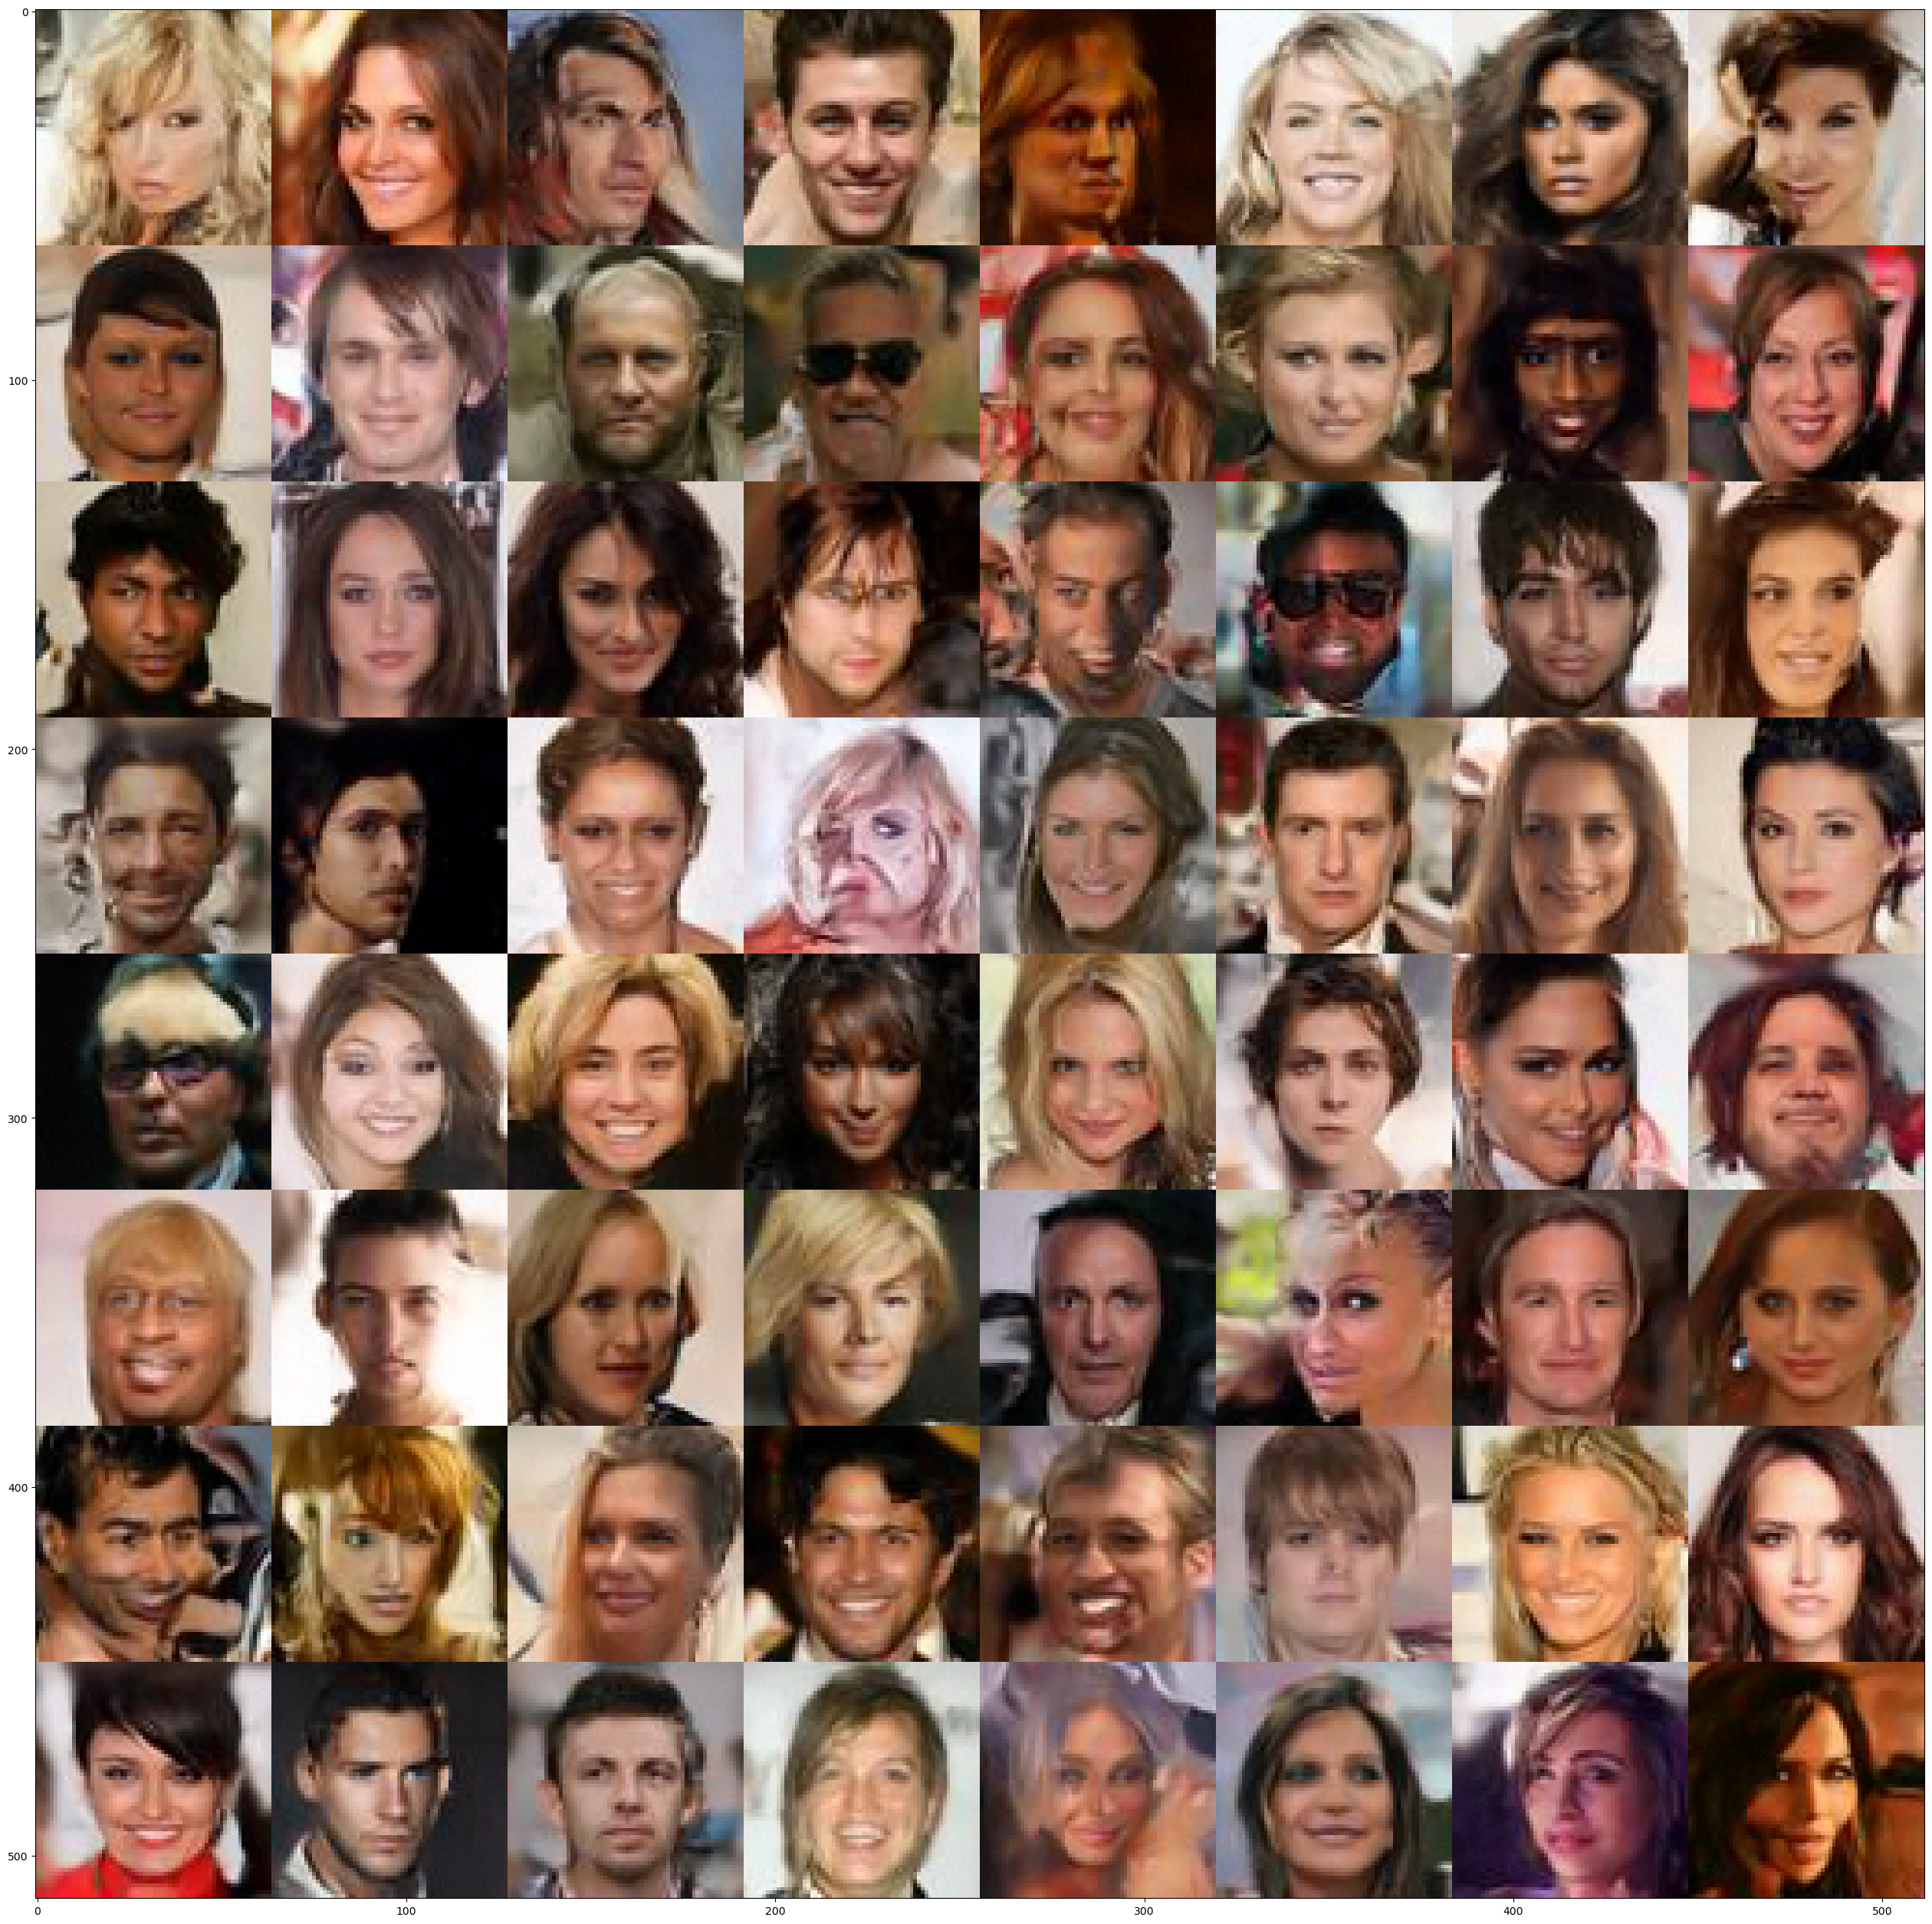

In [12]:
dif = GaussianDiffusion('linear')   

model = Unetvf(3,64,4,64).to('cuda')
#model.load_state_dict(torch.load("current_training_DDIM.pt"))

model.load_state_dict(torch.load("model_arthur_v2tris.pt"))


#model.load_state_dict(torch.load("celeb_partial.pt"))
nb = 64
x_test = torch.randn((nb, 3, 64, 64)).to('cuda')
t = torch.cat((torch.arange(0,999, 25).int(), torch.tensor([999])))
print(t)


sample = dif.DDIM_sampling(model,nb,t, x_test)
#sample2 = dif.sample(model, nb, x=x_test)


print(sample[0, :, :, :])
print(sample.shape)
name = 'gen_64_DDPM_.pdf'

plot_images(sample, 8, 8, name)

#plot_images(sample2)

# METRICS FID

In [13]:
from piqa import FID

upS = nn.Upsample(size=(299,299), mode='bilinear').type(torch.FloatTensor)

def compute_FID(real_features, features_fake):
    fidClass = FID().to('cuda')
            
    return fidClass(real_features, features_fake)

In [14]:
tr_base = transforms.Compose([
    transforms.ToTensor(),
])

datasetMetric = ImageDataset(list_images['metric'],featuresLearning, transform = tr_base)
loaderMetric = data.DataLoader(datasetMetric, batch_size = 50, shuffle= True, num_workers = 2)

In [21]:
fidClass = FID().to('cuda')

test = 1

features_real = None
with torch.no_grad():
    for images, _ in tqdm(loaderMetric):
        
        images = images.to('cuda')
        
        feats = fidClass.features(upS(images), no_grad=True)
        
        if features_real is None:
            features_real = feats
        else:
            features_real = torch.vstack((features_real, feats))
            
        if torch.min(images) < 0 or torch.max(images) > 1:
            print(torch.min(images))
            print(torch.max(images))
            test = 0

print('stop')

100%|██████████| 200/200 [02:05<00:00,  1.59it/s]

stop


In [15]:
features_real = features
diffusion = GaussianDiffusion('linear') 
fidClass = FID().to('cuda')

model = Unet_v2().to('cuda')
model.load_state_dict(torch.load("model_test_FID_799.pt"))

test = 1

model.eval()
features_fake = None
with torch.no_grad():
    for images, _ in tqdm(loaderMetric):
        
        t = torch.cat((torch.arange(0,999, 1).int(), torch.tensor([999])))
        x_sample = diffusion.DDIM_sampling(model,images.shape[0], t, torch.randn((images.shape[0], 3, IMAGE_SIZE, IMAGE_SIZE)).to('cuda'))
        feats = fidClass.features(upS(x_sample), no_grad=True)
        
        if features_fake is None:
            features_fake = feats
        else:
            features_fake = torch.vstack((features_fake, feats))
            
        if torch.min(x_sample) < 0 or torch.max(x_sample) > 1:
            print(torch.min(x_sample))
            print(torch.max(x_sample))
            
    fid_measure = compute_FID(features_real, features_fake)
    #wandb.log({"epoch": epoch, "FID": fid_measure})

model.train()
print(fid_measure)

NameError: name 'Unet_v2' is not defined

# Training

In [16]:
!pip install wandb -qU
import wandb
wandb.init(project = 'diffusion', entity = "uliege_action_spotting_2022_2023_context", name = "test_FID")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jepi1202 (uliege_action_spotting_2022_2023_context). Use `wandb login --relogin` to force relogin


In [17]:
device = 'cuda'
#model = UNet().to(device)
#model = Unet_v2().to(device)
model = Unetvf(3,64,4,64).to(device)
#model = nn.DataParallel(model)

criterion = nn.MSELoss()                                           # defining the loss
wandb.watch(model, criterion, log="all", log_freq=10)

[]

In [24]:
sum(p.numel() for p in model.parameters())

15645763

In [18]:
upS = nn.Upsample(size=(299,299), mode='bilinear').type(torch.FloatTensor)

def training(dataLoader, model, criterion, nbEpoch, typeSchedule, nb = 3, x=None, device = 'cuda', im_size = IMAGE_SIZE, lr = 0.001, fidBool = 0, saveBool = 1):
    
    optimizer = optim.AdamW(model.parameters(), lr=lr)                 # Adam optimizer with weight decay
    diffusion = GaussianDiffusion(typeSchedule)                             # defining diffusion model
    fidClass = FID().to('cuda')
    stepDDIM = 4
    
    #print(diffusion.alpha_cumprod)
    
    wandb.log({"initial_noise": [wandb.Image(im) for im in x]})
    

    print(f"Starting the training")
    
    for epoch in range(nbEpoch):
        for images, _ in tqdm(dataLoader):
            #print("1")
            images = images.to(device)
            
            
            #print("2")
            t = diffusion.getRandomTimestep(images.shape[0]).to(device)   # sample random timesteps
            x_t, noise = diffusion.noise_images(images, t)               # noise images

        
            
            #print("3")
            predicted_noise = model(x_t, t)
            loss = criterion(noise, predicted_noise)
            #print(loss)
            #print("4")
            
            wandb.log({"epoch": epoch, "loss": loss})

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #print('5')
            
            torch.cuda.empty_cache()
            
        if ((epoch +1)%30 == 0):
            print(epoch)
            model.eval()
            with torch.no_grad():
                #x_sample = diffusion.sample(model, n=nb, x=x)
                t = torch.cat((torch.arange(0,999, stepDDIM).int(), torch.tensor([999])))
                x_sample = diffusion.DDIM_sampling(model, nb, t, x)

                wandb.log({"sample_diffusion": [wandb.Image(image) for image in x_sample]})
            model.train()
        
        #print(loss.item())
        
        if fidBool:
            if((epoch +1)%100 == 0):
                model.eval()
                features_fake = None
                with torch.no_grad():
                    for images, feats in tqdm(loaderMetric):

                        #x_sample = diffusion.sample(model, n=images.shape[0], x = torch.randn((images.shape[0], 3, IMAGE_SIZE, IMAGE_SIZE)).to('cuda'))
                        t = torch.cat((torch.arange(0,999, stepDDIM).int(), torch.tensor([999])))
                        x_sample = diffusion.DDIM_sampling(model,images.shape[0], t, torch.randn((images.shape[0], 3, IMAGE_SIZE, IMAGE_SIZE)).to('cuda'))
                        feats = fidClass.features(upS(x_sample), no_grad=True)

                        if features_fake is None:
                            features_fake = feats
                        else:
                            features_fake = torch.vstack((features_fake, feats))

                        if(features_fake.shape[0] > 30000):
                            break



                    fid_measure = compute_FID(features, features_fake)
                    wandb.log({"epoch": epoch, "FID": fid_measure})
                model.train()
        
        if saveBool:
            if((epoch +1)%20 == 0):
                torch.save(model.state_dict(), 'current_training_DDIM.pt')
                

            
    return model

        #im = diffusion.sample(model, n=images.shape[0])         # images to save in wb
        #save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
        #torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))

In [ ]:
#torch.cuda.empty_cache()
nb = 5
x = torch.randn((nb, 3, 64, 64)).to('cuda')
mod0 = training(loaderLearning, model, criterion, 5000, typeSchedule='linear', nb=5, x=x)

# INPAINTING

In [20]:
def plot_inpainting(model, images, masks, inv_masks, tr_base, name='test_inapinting.pdf', nb_gen = 6):
    
    dif = GaussianDiffusion('linear')  
    
    imagesMerged = None
    
    for im, m, inv_m in tqdm(zip(images, masks, inv_masks)):
        im = tr_base(im).to('cuda')
        im2 = (im + 1)/2
        
        im_mask = m * im2
        
        im = im.reshape(1,3,64,64)
        im = im.repeat(nb_gen, 1, 1, 1)
        
        im_inp = dif.repaint(nb_gen, im.to("cuda"),model,2, mask = m, inv_mask=inv_m)
        
        im_inp2 = (im_inp + 1)/2
        
        vect = torch.cat((im2.reshape(1,3,64,64), im_mask.reshape(1,3,64,64), im_inp2.reshape(nb_gen,3,64,64)), dim=0)
        
        if imagesMerged is None:
            imagesMerged = vect
        else:
            imagesMerged = torch.cat((imagesMerged, vect))
            
        print(imagesMerged.shape)
            
    
    plot_images(imagesMerged, nb_gen+2,len(masks), name)
    
    return imagesMerged

In [21]:
def compare_inpainting(model, images, masks, inv_masks, tr_base, name='test_inapinting.pdf', nb_gen = 6):
    
    dif = GaussianDiffusion('linear')  
    
    imagesMerged = None
    
    for i in tqdm(range(len(masks))):
        im, m, inv_m = images[i], masks[i], inv_masks[i]
        
        im = tr_base(im).to('cuda')
        im2 = (im + 1)/2
        
        im_mask = m * im2
        
        im = im.reshape(1,3,64,64)
        im = im.repeat(nb_gen, 1, 1, 1)
        
        if(i == 0):
            im_inp = dif.repaint(nb_gen, im.to("cuda"),model,1, mask = m, inv_mask=inv_m)
        
        if(i == 1):
            im_inp = dif.repaint(nb_gen, im.to("cuda"),model,2, mask = m, inv_mask=inv_m)
            
        if(i == 2):
            im_inp = dif.repaint(nb_gen, im.to("cuda"),model,5, mask = m, inv_mask=inv_m)
        
        if(i == 3):
            im_inp = dif.repaint(nb_gen, im.to("cuda"),model,10, mask = m, inv_mask=inv_m)
            
        if(i == 4):
            im_inp = dif.repaint(nb_gen, im.to("cuda"),model,15, mask = m, inv_mask=inv_m)
        
        if(i == 5):
            im_inp = dif.repaint(nb_gen, im.to("cuda"),model,20, mask = m, inv_mask=inv_m)
        
        im_inp2 = (im_inp + 1)/2
        
        vect = torch.cat((im2.reshape(1,3,64,64), im_mask.reshape(1,3,64,64), im_inp2.reshape(nb_gen,3,64,64)), dim=0)
        
        if imagesMerged is None:
            imagesMerged = vect
        else:
            imagesMerged = torch.cat((imagesMerged, vect))
            
        print(imagesMerged.shape)
            
    
    plot_images(imagesMerged, nb_gen+2,len(masks), name)
    
    return imagesMerged

In [22]:
from copy import deepcopy

im = Image.open("louppe.jpg").resize((64,64))

x_0 = torch.ones((1,3,64,64))

mask1 = torch.ones_like(x_0).to('cuda')
inv_mask1 = torch.zeros_like(x_0).to('cuda')
inv_mask1[:, :,10:30,10:50] = 1
mask1[:, :,10:30,10:50] = 0

mask2 = torch.ones_like(x_0).to('cuda')
inv_mask2 = torch.zeros_like(x_0).to('cuda')
inv_mask2[:, :,32:,:] = 1
mask2[:, :,32:,:] = 0

mask3 = torch.ones_like(x_0).to('cuda')
inv_mask3 = torch.zeros_like(x_0).to('cuda')
inv_mask3[:, :,:,32:] = 1
mask3[:, :,:,32:] = 0

mask4 = torch.ones_like(x_0).to('cuda')
inv_mask4 = torch.zeros_like(x_0).to('cuda')
for j in range(64):
    if(j % 2 == 0):
        inv_mask4[:, :,j,:] = 1
        mask4[:, :,j,:] = 0
        
mask5 = torch.ones_like(x_0).to('cuda')
inv_mask5 = torch.zeros_like(x_0).to('cuda')
for j in range(64):
    if(j % 2 == 0):
        inv_mask5[:, :,:,j] = 1
        mask5[:, :,:,j] = 0
        
        

imList = []
mask_list = [mask1, mask2, mask3, mask4, mask5]
inv_mask_list = [inv_mask1, inv_mask2, inv_mask3, inv_mask4, inv_mask5]
for i in range(5):
    imList.append(deepcopy(im))

In [ ]:
dif = GaussianDiffusion('linear')   

#model.load_state_dict(torch.load("model_arthur_v2tris.pt"))
model.load_state_dict(torch.load("current_training_DDIM.pt"))



tr_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),           # modify those values ?
])

res = plot_inpainting(model, imList, mask_list, inv_mask_list, tr_base)

In [ ]:
from copy import deepcopy

im = Image.open("louppe.jpg").resize((64,64))

x_0 = torch.ones((1,3,64,64))

mask1 = torch.ones_like(x_0).to('cuda')
inv_mask1 = torch.zeros_like(x_0).to('cuda')
inv_mask1[:, :,10:30,10:50] = 1
mask1[:, :,10:30,10:50] = 0

mask2 = torch.ones_like(x_0).to('cuda')
inv_mask2 = torch.zeros_like(x_0).to('cuda')
inv_mask2[:, :,32:,:] = 1
mask2[:, :,32:,:] = 0

mask3 = torch.ones_like(x_0).to('cuda')
inv_mask3 = torch.zeros_like(x_0).to('cuda')
inv_mask3[:, :,:,32:] = 1
mask3[:, :,:,32:] = 0

mask4 = torch.ones_like(x_0).to('cuda')
inv_mask4 = torch.zeros_like(x_0).to('cuda')
for j in range(64):
    if(j % 2 == 0):
        inv_mask4[:, :,j,:] = 1
        mask4[:, :,j,:] = 0
        
mask5 = torch.ones_like(x_0).to('cuda')
inv_mask5 = torch.zeros_like(x_0).to('cuda')
for j in range(64):
    if(j % 2 == 0):
        inv_mask5[:, :,:,j] = 1
        mask5[:, :,:,j] = 0
        
        

imList = []
mask_list = [mask1, mask1, mask1, mask1, mask1, mask1]
inv_mask_list = [inv_mask1, inv_mask1, inv_mask1, inv_mask1, inv_mask1, inv_mask1]
for i in range(6):
    imList.append(deepcopy(im))

    

In [ ]:
model.load_state_dict(torch.load("model_arthur_v2tris.pt"))



tr_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),           # modify those values ?
])

res = compare_inpainting(model, imList, mask_list, inv_mask_list, tr_base, name = 'mask2.pdf')